Optional A for the Project of DLAI Fall semester 2019/2020.

Authors:
*   Roser Batlle Roca
*   Jordi Biosca Caro
*   María González i Calabuig
*   Carlos Alejandro López Molina


In [0]:
import torch

import numpy as np
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data.sampler import SubsetRandomSampler
from tabulate import tabulate

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

In [0]:
hparams = {
    'batch_size': 64,
    'num_epochs': 5,
    'test_batch_size': 64,
    'hidden_size': 64,
    'hidden_size_2': 128,
    'hidden_size_3': 64,
    'num_classes': 10,
    'num_inputs': 1, 
    'learning_rate': 1e-3,
    'log_interval': 100,
    'num_workers': 4,
    'kernel_size': 3,
    'encoder_key': [1, 5, 25, 50, 100]
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

num_train = len(mnist_trainset)
indices = list(range(num_train))
test_size = 0.05
split = int(np.floor(test_size * num_train))

train_id, test_id = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_id)

test_sampler = SubsetRandomSampler(test_id)

train_loader = torch.utils.data.DataLoader(mnist_trainset, 
                                           hparams['batch_size'], 
                                           shuffle=False,
                                           sampler=train_sampler,
                                           num_workers=hparams['num_workers'], 
                                           )

test_loader = torch.utils.data.DataLoader(mnist_trainset, 
                                          hparams['batch_size'], 
                                          shuffle=False,
                                          sampler=test_sampler,
                                          num_workers=hparams['num_workers'], 
                                          )


0it [00:00, ?it/s]

9920512it [00:02, 4003172.47it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57424.51it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 883074.17it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 22131.15it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


![Gaussian Variationa Autoencoder](https://blog.bayeslabs.co/assets/img/vae-gaussian.png)

In [0]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class VAE(nn.Module):

  def __init__(self):
    super(VAE,self).__init__()

    self.fc1m = nn.Linear(25, 10)
    self.fc1s = nn.Linear(25, 10)
    self.fc2 = nn.Linear(10, 25)
    
    self.encoder = nn.Sequential(
        nn.Conv2d(hparams['num_inputs'], hparams['hidden_size'], 4, padding=3, stride=2),
        nn.ReLU(True),
        nn.Conv2d(hparams['hidden_size'], hparams['hidden_size_2'], 4, padding=1, stride=2),
        nn.ReLU(True),
        nn.Conv2d(hparams['hidden_size_2'], hparams['hidden_size_3'], 4, stride=2),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=1),
        nn.ReLU(True),
        nn.Flatten(),
        nn.Linear(2*2*hparams['hidden_size_3'], 25)
    )
    

    self.decoder = nn.Sequential(
        nn.Linear(25, 2*2*hparams['hidden_size_3']),
        nn.ReLU(True),
        Reshape(-1,hparams['hidden_size_3'], 2, 2),
        nn.ConvTranspose2d(hparams['hidden_size_3'], hparams['hidden_size_2'], 3, stride=2),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden_size_2'], hparams['hidden_size'], 5, stride=3, padding=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden_size'], hparams['num_inputs'], 2, stride=2, padding=1),
        nn.Tanh(),
    )

  def encode(self,x):
    bsz = x.shape[0]
    x = self.encoder(x)
    y = x
    x = x.view(bsz,-1)
    return  self.fc1m(x),self.fc1s(x), y.shape
    
  #Explicació a la imatge
  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    if torch.cuda.is_available():
        eps = torch.cuda.FloatTensor(std.size()).normal_()
    else:
        eps = torch.FloatTensor(std.size()).normal_()
    eps = Variable(eps)
    return eps.mul(std).add_(mu)

  def forward(self,x):
    mu, logvar, shape = self.encode(x)
    x = self.reparametrize(mu, logvar)
    x = self.fc2(x)
    #Falta transformar els 1280 a vector o canviar el decoder
    x = x.view(shape)
    x = self.decoder(x)
    return x, mu, logvar

In [25]:
# Trainning process
reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

model = VAE()
model = model.to(hparams['device'])
distance = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'], weight_decay=1e-5)
losses_train = [] 
losses_test = []
for epoch in range (hparams['num_epochs']):
  for batch_id,data in enumerate(train_loader):
    img, _ = data
    img = img.to(hparams['device'])
    groundtruth = groundtruth.to(hparams['device'])
    # Forward pass
    output, mu, logvar = model(img)
    loss = loss_function(output, img, mu, logvar)
    losses_train.append(loss.cpu().data.item())
    # Backward pass
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
  for data in test_loader:
    img, _ = data
    img = img.to(hparams['device'])
    output = model(img)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


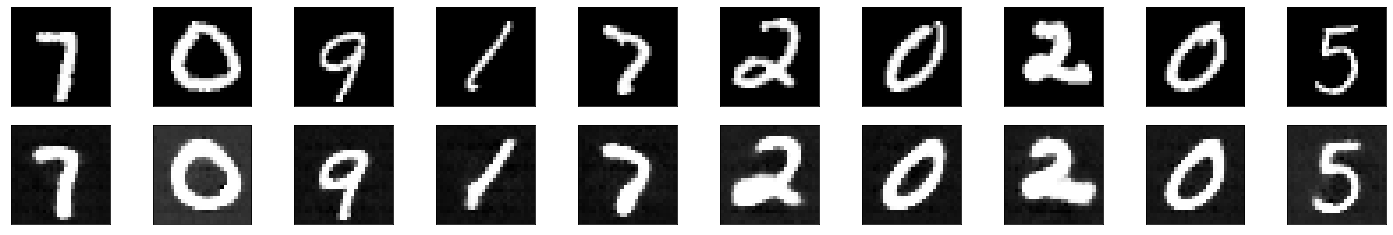

In [31]:
for data in test_loader:
    img, _ = data
    model.eval()
    model.to('cpu')
    output, _, _ = model(img)

    output = output.to('cpu')
    output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([img, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

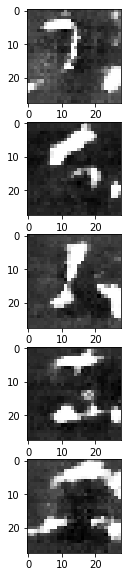

In [33]:
rand_img = 5*torch.rand(5,hparams['encoder_key'][2])
# model[3].eval()
# model[3].to('cpu')
model.to('cpu')

output = model.decoder(rand_img)

output = output.to('cpu')
output = output.detach().numpy()

fig, axes = plt.subplots(5,figsize=(10,10))
for i in range(5):
  axes[i].imshow(np.squeeze(output[i, :]), cmap='gray')